In [ ]:
!pip install nidaqmx

In [ ]:
import os.path

import matplotlib.pyplot as plt
from IPython.display import clear_output
import nidaqmx as daq
import numpy as np
import pandas as pd
from nidaqmx.constants import AcquisitionType
from datetime import datetime
%matplotlib inline

In [ ]:
def acquire(N, fs, max_channel=0, file_out='', output='X', time_sep=1, zero_bound=True, daq_name='cDAQ1Mod1', 
            mod_type='ai', plt_sp_fft=False, han_window=False):    
    """Acquires AI Voltage and Displays/Logs Data
         
    Args:
        N           (int):  Number of samples to measure. 
        fs        (float):  Sampling frequency in Hz. 
        max_channel (int):  Maximum voltage channel to read from.
            Default Value:  0
            Example Usage:  (int) in range 0-7 for AI, 0-3 for TC.
        file_out (String):  Output directory and file name of initial output. 
            Default Value:  ''
            Example Usage:  'C:\\Users\\Josh\\Downloads\\Lab2_0.csv'
        output   (String):  Type of output. 
            Default Value:  'X', outputs no file.
            Example Usage:  'N', creates new file every trial.
            Example Usage:  'R', replaces data in last trial. 
            Example Usage:  'A', appends new data to last trial.
        time_sep  (float):  Time increment to update live plot in seconds.
            Default Value:  1
            Example Usage:  (float) > = 1, must be increased when taking large amounts of data (N > 100e3). 
        zero_bound (bool):  Determines whether live graph is bounded to 0.
            Default Value:  True
        daq_name (String):  Name of DAQ card/system.
            Default Value:  'cDAQ1Mod1'
            Example Usage:  'cDAQ1Mod4'
        mod_type (String):  Type of DAQ card.
            Default Value:  'ai', analog input.
            Example Usage:  'tc', thermocouple. 
            Example Usage:  'pr', analog input with small differential voltage. 
        plt_sp_fft (bool):  Plots frequency spectrum using Fast Fourier Transform (FFT).
            Default Value:  False
        han_window (bool):  Applies a Hanning window to the plot output.
            Default Value:  False
    """
    plt.ioff()
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['k', 'red', 'darkorange', 'limegreen', 'lightseagreen', 
                                                        'teal', 'lightpink', 'slategray']) 
    replace = True
    append = False
    
    if output == 'A': append = True
    elif output == 'N': replace = False
    elif output != 'R': file_out = ''
    
    dt = np.arange(0, N, 1) / fs
    if max_channel < 0: max_channel = 0
    elif mod_type == 'ai' and max_channel > 7: max_channel = 7
    elif mod_type != 'ai' and max_channel > 3: max_channel = 3
    
    with daq.Task() as task:
        if mod_type == 'ai':
            task.ai_channels.add_ai_voltage_chan(daq_name + '/ai0:' + str(max_channel))
        elif mod_type == 'pr':
            task.ai_channels.add_ai_voltage_chan(daq_name + '/ai0:' + str(max_channel), min_val=-.08, max_val=.08)
        else: 
            task.ai_channels.add_ai_thrmstr_chan_vex(daq_name + '/ai0:' + str(max_channel))
        task.timing.cfg_samp_clk_timing(rate=float(fs), samps_per_chan=int(N), sample_mode=AcquisitionType.CONTINUOUS)
        
        time = datetime.now().strftime('%H:%M:%S.%f')
        date = datetime.now().strftime('%Y-%m-%d')
        
        data = np.array(list())
        
        if time_sep < 1: time_sep = 1
        if plt_sp_fft and time_sep == 1: time_sep = 120
        Nm = time_sep * fs
        k = int(np.ceil(N / Nm))
        for i in range(0, k):
            Nr = int(Nm) if (i < k - 1 or N % Nm == 0) else int(N % Nm)
            temp = np.array((task.read(Nr, timeout=daq.constants.WAIT_INFINITELY)))
            if len(data) == 0: data = temp
            else: data = np.append(data, temp, axis=(1 if max_channel > 0 else 0))
            
            fig, ax = plt.subplots(figsize=(16, 8))
        
            pos1 = int(i * Nm) if not zero_bound and i < k - 1 else 0
            pos2 = int((i + 1) * Nm) if i < k else len(dt)
            
            clear_output(wait=True)
            if max_channel == 0:
                if not han_window:
                    plt.plot(dt[pos1:pos2], data[pos1:pos2], label='ai0')
                    if plt_sp_fft: fft_plot(dt[:pos2], data[:pos2], len(dt[:pos2]))
                else:
                    u = .5 * (1 - np.cos(2 * np.pi * dt / max(dt)))
                    plt.plot(dt[pos1:pos2], u[pos1:pos2] * data[pos1:pos2], label='ai0')
                    if plt_sp_fft: fft_plot(u[:pos2] * dt[:pos2], u[:pos2] * data[:pos2], len(dt[:pos2]))
            else:
                for j in range(0, max_channel + 1):
                    plt.plot(dt[pos1:pos2], data[j][pos1:pos2], label='ai' + str(j))
            plt.grid()
            plt.legend(loc='upper right') 
            plt.pause(1e-30)
            plt.show()

        if len(file_out) > 0:
            num = 0
            while os.path.isfile(file_out):
                num = int(file_out.rsplit('_', 1)[1][0:-4]) + 1
                file_out = file_out.rsplit('_', 1)[0] + '_' + str(num) + '.csv'
            if replace and num > 0:
                num -= 1
                file_out = file_out.rsplit('_', 1)[0] + '_' + str(num) + '.csv'
            
            system = daq.system.System.local()
            driv_split = str(system.driver_version).split(',')
            driver = driv_split[0][-2:] + '.' + driv_split[1][-1:] + '.' + driv_split[2][-2:-1]
            device = str(system.devices[daq_name].product_type)
            
            header = '# ' + date + ', ' + time + '\n# fs = ' + str(round(fs)) + ' Hz, N = ' + str(round(N)) 
            header += '\n# ' + str(device) + ', ' + driver
            
            file = None
            if append:
                isFile = os.path.isfile(file_out)
                file = open(file_out, 'a')
                if isFile: file.write('\n')
            else:
                file = open(file_out, 'w')
            file.write(header + '\n')
            
            df = pd.DataFrame(np.transpose(data), 
                              columns=['ai0', 'ai1', 'ai2', 'ai3', 'ai4', 'ai5', 'ai6', 'ai7'][0: max_channel + 1])
            df.insert(0, 't', dt)
            df.to_csv(file, sep=',', index=False, float_format='%.9f', line_terminator='\n')
            
            file.close()

def fft_plot(t, data, N):
    plt.grid()
    plt.legend(loc='upper right') 
    plt.show()
    
    T = max(t)
    sp = np.fft.fft(data)[:int(len(t) / 2)]
    f = np.arange(int(N))[:len(sp)] / T

    fig = plt.figure(figsize=(16, 8))
    plt.scatter(f, abs(sp), c='k', alpha=.8)
    plt.plot(f, abs(sp), c='k', alpha=.6, label='Frequency')
    plt.grid()
    plt.grid();

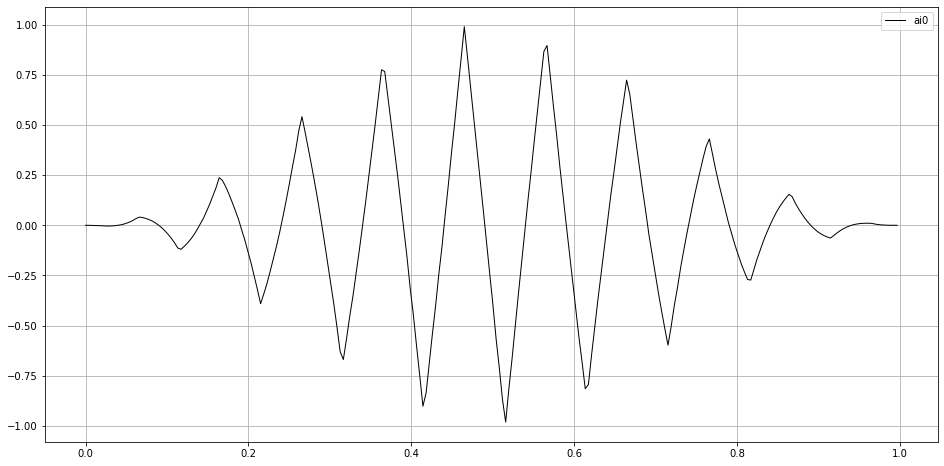

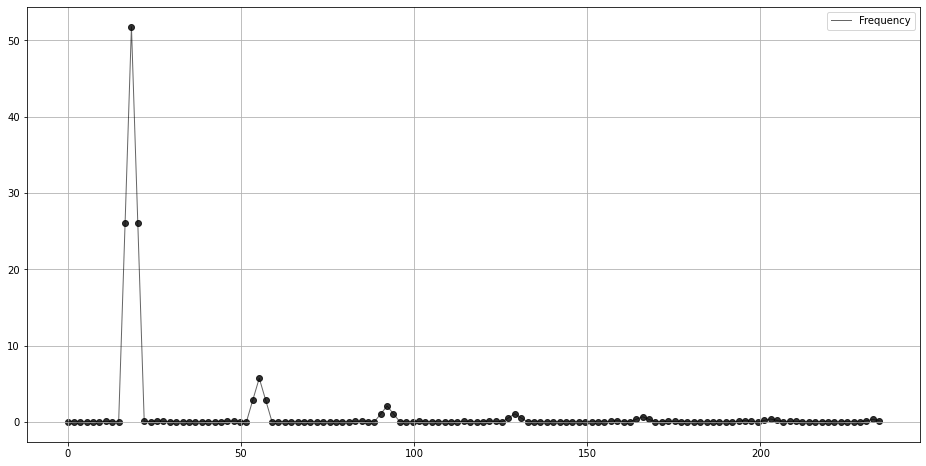

In [ ]:
FILE_OUT = './PtVI-triangle-window'
fs = 256
N = 256

acquire(N, fs, plt_sp_fft=True, han_window=True, file_out=FILE_OUT, output="N")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=385eace9-e066-4866-bb55-3a1ff5bdb476' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>